In [ ]:
import os, sys 
sys.path.append(os.getcwd())
from pyWebREPL import WEBREPL

webrepl = WEBREPL(host='192.168.1.105', password='123456')
 
webrepl.send('''
import time  
from machine import Pin  
PIN_BUILTIN_LED = 2 
p2 = Pin(PIN_BUILTIN_LED, Pin.OUT, value=1)   
p2.off()  # Turn on the on-board LED            
time.sleep(0.5) 
p2.on()   # Turn off the on-board LED   
''')
print(webrepl.recv())

webrepl.close()

In [ ]:
import os, sys 
sys.path.append(os.getcwd())
from pyWebREPL import WEBREPL

webrepl = WEBREPL(host='192.168.1.105', password='123456')
 
webrepl.send('''
import utime 
from machine import Pin

EN_PIN = 15
en_pin = Pin(EN_PIN, Pin.OUT)
DIR_PIN = 12
dir_pin = Pin(DIR_PIN, Pin.OUT)
STEP_PIN = 13
step_pin = Pin(STEP_PIN, Pin.OUT)
 
en_pin.value(0)
dir_pin.value(0)
step_pin.value(1)


def stepOne():
  step_pin.value(1)
  utime.sleep_us(1)
  step_pin.value(0)
  utime.sleep_us(1)
 

for i in range(1600):
    stepOne() 
    utime.sleep_ms(2)

''')
print(webrepl.recv())

webrepl.close()

In [ ]:
import os, sys 
sys.path.append(os.getcwd())
from pyWebREPL import WEBREPL

webrepl = WEBREPL(host='192.168.0.108', password='123456')
 
webrepl.send(''' 
dir_pin.value(1) 
 
for i in range(3200):
    stepOne() 
    utime.sleep_ms(2) 
''')
print(webrepl.recv())

webrepl.close()

In [ ]:
import socket, threading
def logger(): 
    s = socket.socket(family=socket.AF_INET, type=socket.SOCK_DGRAM) 
    s.bind(("0.0.0.0", 54321)) 
    s.settimeout(10) 
    with open('stepper.log','wb') as fw:
        count = 0
        while True: 
            try:
                buf = s.recv(6)
            except socket.timeout: 
                fw.flush()
                print(f'[{count}] no new data, timeout')
                s.close()
                break
            fw.write(buf)
            count += 1
            if count % 5000 == 0: 
                print(f'[{count}] flush')
                fw.flush()

threading.Thread(target=logger).start()

In [ ]:
import os, sys 
sys.path.append(os.getcwd())
from pyWebREPL import WEBREPL

webrepl = WEBREPL(host='192.168.1.105', password='123456')
 
webrepl.send(''' 
import utime, socket 
from machine import Pin, I2C 

i2c = I2C(scl=Pin(5), sda=Pin(4), freq=100000) 
ENCODER_DIR_PIN = 0
dir_pin = Pin(ENCODER_DIR_PIN, Pin.OUT, value=1) 

s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) 

buf1 = bytearray(2) 
for i in range(200000):
    i2c.readfrom_mem_into(0x36, 0x0C, buf1)
    _ = s.sendto(utime.ticks_ms().to_bytes(4, 'big') + buf1, ('192.168.1.22', 54321)) 
    utime.sleep_ms(1)
    
''')
#print(i2c.readfrom_mem(0x36, 0x0C, 1))
#print(i2c.readfrom_mem(0x36, 0x0D, 1)) 
print(webrepl.recv())

webrepl.close()

In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, io
from matplotlib import font_manager, lines
from IPython.core.display import HTML 
#pd.set_option('display.max_rows', None)
plt.style.use('_mpl-gallery') 

font_dirs = ['/var/www/html/software/font/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)  

plt.rcParams['font.family'] = "JMH" #  "Times New Roman"
plt.rcParams['font.size'] = 18
plt.rcParams['figure.constrained_layout.use'] = True

import struct 
data = []
with open('stepper.log','rb') as fr:
    while True:
        buf = fr.read(6)
        if not buf : break
        tick, angle = struct.unpack('>ih', buf)
        data.append((tick, angle)) 

df = pd.DataFrame(data, columns=['ticks_ms', 'angle']) 

df['motionless'] = None   

row_idx =  0 # 倒查，y wei
gap = 1000
while True:
    if row_idx + gap > df.index.stop: 
        break
    count = 0
    for idx in range(gap): 
        if abs(df.loc[row_idx + idx, 'angle'] - df.loc[row_idx, 'angle']) < 10: 
            pass
        else: 
            for sub_idx in range(idx): 
                df.loc[row_idx + sub_idx, 'motionless'] = False
            row_idx = row_idx + idx 
            break
    else: 
        for idx in range(gap): 
            df.loc[row_idx + idx, 'motionless'] = True  
        row_idx += gap 

df['dAngle'] = None 
for i in range(1, df.index.stop):
    df.loc[i, 'dAngle'] = (df.loc[i, 'angle'] - df.loc[i-1, 'angle']) / (df.loc[i, 'ticks_ms'] - df.loc[i-1, 'ticks_ms'])

for idx, row in df.iterrows():
    try:
        if row['motionless'] != df.loc[idx+1, 'motionless']:
            df.loc[idx, 'dAngle'] = 9999
    except:
        pass 

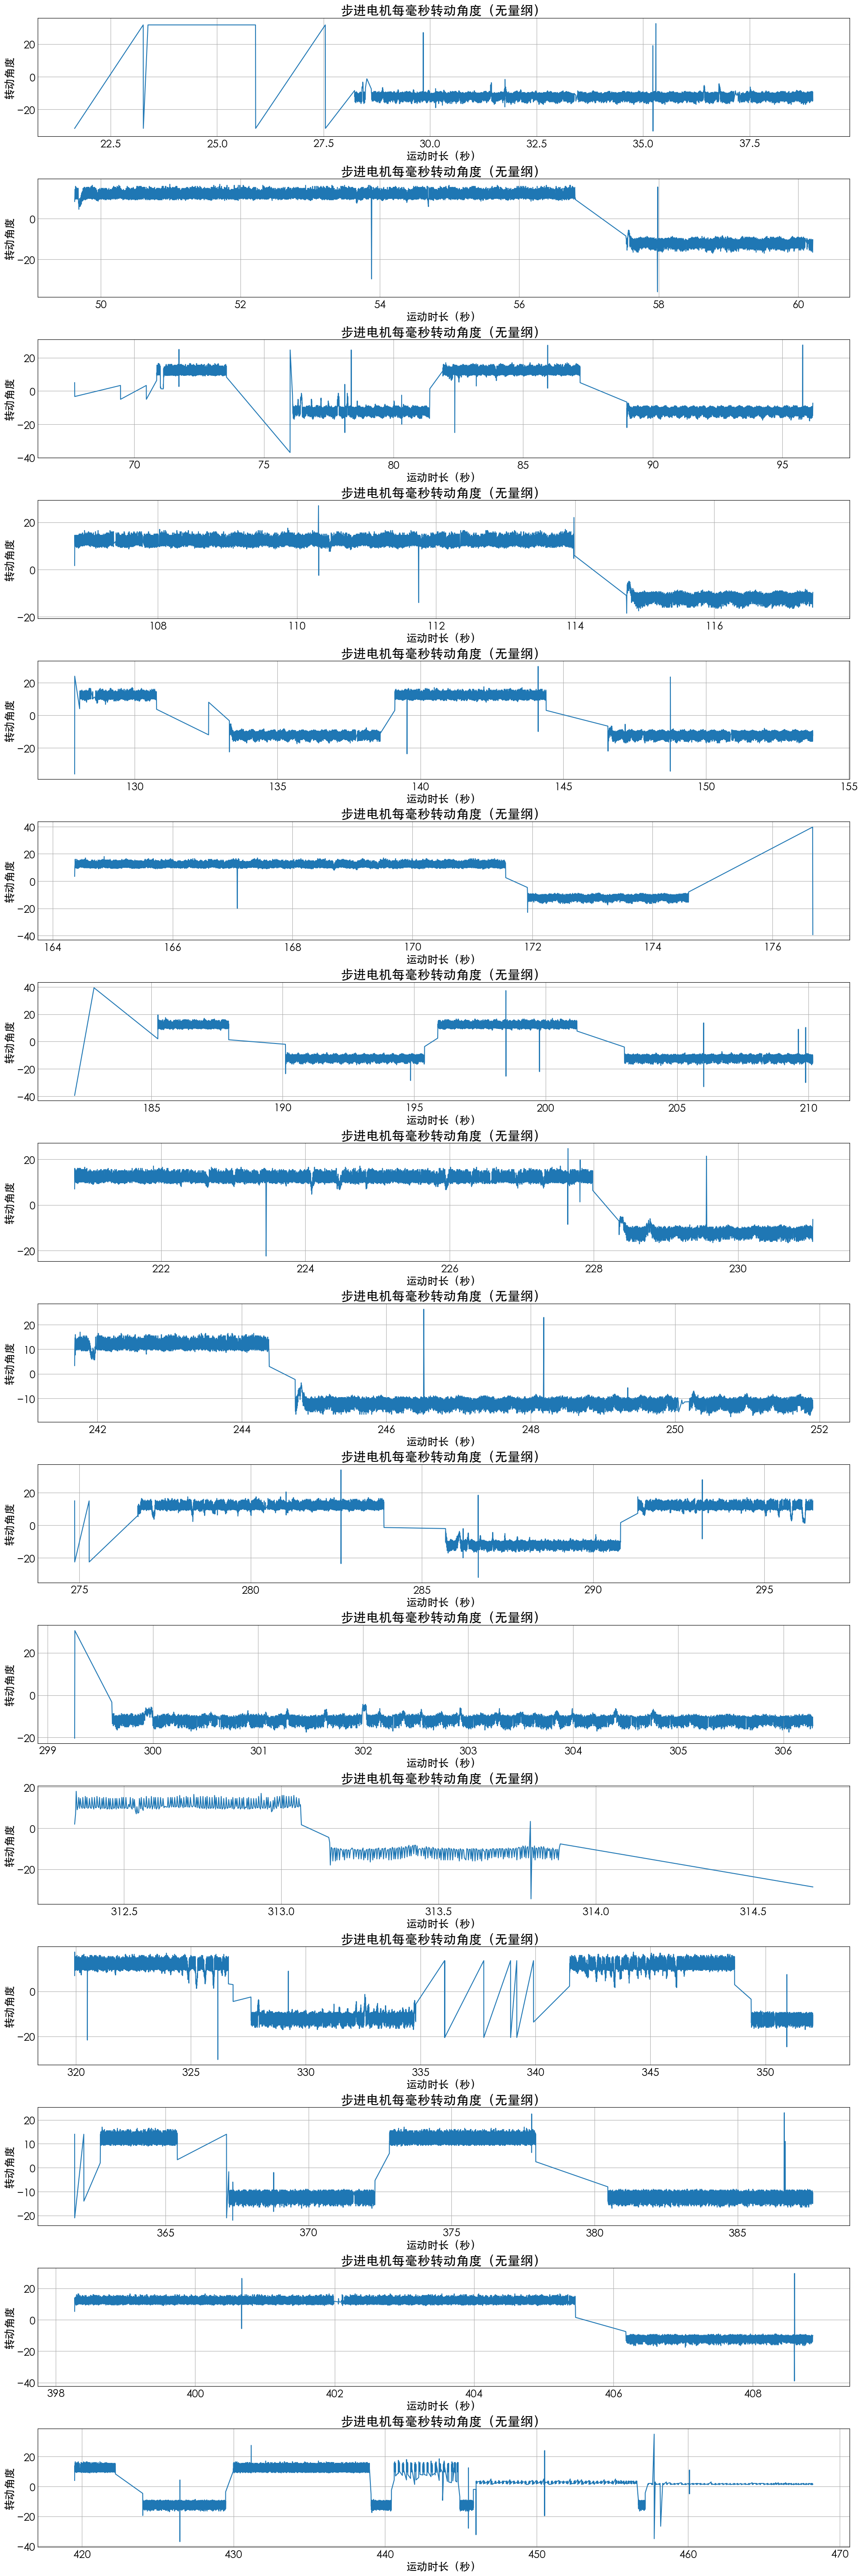

In [2]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, io
from matplotlib import font_manager, lines
from IPython.core.display import HTML 
#pd.set_option('display.max_rows', None)
plt.style.use('_mpl-gallery') 

font_dirs = ['/var/www/html/software/font/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
old_ttflist = set([i.name for i in font_manager.fontManager.ttflist])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file) 
new_ttflist = set([i.name for i in font_manager.fontManager.ttflist])
if new_ttflist.difference(old_ttflist):
    print('[new fonts] ' + ', '.join(new_ttflist.difference(old_ttflist)))
    
plt.rcParams['font.family'] =  "STHeiti"#  "JMH"
plt.rcParams['font.size'] = 18
plt.rcParams['figure.constrained_layout.use'] = True
 
_df = df.copy()

ticks_ms = _df.iloc[0, 0]
_df['ticks_ms'] = _df.apply(lambda x: x['ticks_ms']-ticks_ms, axis=1)

node = _df[_df['dAngle']==9999].index

pd.set_option('display.max_rows', None) 

j = 0
fig, ax = plt.subplots(16, 1, figsize=(20, 60)) 
for i in range(len(node)-1): 
     
    df = _df[node[i]: node[i+1]].copy()
    df = df[(df['dAngle']>-40) & (df['dAngle']<40)] 
    df = df[(df['dAngle']<-1) | (df['dAngle']> 1)] 
    df = df[df['motionless']==False].reset_index(drop=True)
    if len(df) < 10: continue
    
    ax[j].plot([i * 0.001 for i in df['ticks_ms'].to_list()], df['dAngle'].to_list())  
    ax[j].set_title(f'步进电机每毫秒转动角度（无量纲）') 
    ax[j].set_xlabel('运动时长（秒）') 
    ax[j].set_ylabel('转动角度')  
    ax[j].tick_params(axis='both', which='major')  
    ax[j].ticklabel_format(useMathText=True, useOffset=False)  
    j += 1
    pass#fig.savefig(f'sm/{i//4+1}.png') 

fig.savefig(f'sm.png') 